# Measuring Synaptic Short Term Plasticity

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to measure short term plasticity and its relationship to cell subclass.

For an introduction to the Jupyter Notebook interface interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


In [1]:
import numpy as np
import scipy.stats
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, pair_was_probed

### 1. Load the data

First, load up the "small" database from release 1.0 and query all cell `pairs` for mouse projects.

In [2]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_current('small')

# Load all synapses associated with mouse V1 projects
pairs = db.pair_query(
    project_name=["mouse V1 coarse matrix", "mouse V1 pre-production"],
    synapse=True,
).all()

print("loaded %d synapses" % len(pairs))

loaded 1789 synapses


## 2. Classify cells

We will pick four simple class defintions for this analysis:

In [3]:
cell_classes = {
    'pyr': CellClass(cell_class='ex', name='pyr'),
    'pvalb': CellClass(cre_type='pvalb', name='pvalb'),
    'sst': CellClass(cre_type='sst', name='sst'),
    'vip': CellClass(cre_type='vip', name='vip'),
}   

In [4]:
# get a list of all cells in the selected pairs
cells = set([pair.pre_cell for pair in pairs] + [pair.post_cell for pair in pairs])

# Classify each cell. Note that, depending on the class definitions above, a cell could 
# belong to multiple classes. 
cell_class = {}
for cell in cells:
    # which of the classes defined above is this cell a member of?
    cell_in_classes = [cls_name for cls_name, cls in cell_classes.items() if cell in cls]
    cell_class[cell] = ','.join(cell_in_classes)

## 3. Construct a dataframe

Now we build a dataframe with one row per synapse that contains the pre/postsynaptic cell class names as well as a measure of short-term plasticity.

In [5]:
import pandas

# construct a pandas dataframe containing the pre/postsynaptic cell class names
# and a measure of short-term plasticity
pre_class = [cell_class[pair.pre_cell] for pair in pairs]
post_class = [cell_class[pair.post_cell] for pair in pairs]
stp = [None if pair.dynamics is None else pair.dynamics.stp_induction_50hz for pair in pairs]

df = pandas.DataFrame(
    zip(pairs, pre_class, post_class, stp), 
    columns=['pair', 'pre_class', 'post_class', 'stp']) 

# select out only cells that are a member of exactly 1 class
mask = df.pre_class.isin(cell_classes) & df.post_class.isin(cell_classes)
df = df[mask]

# select only pairs with a measured stp
df = df.dropna()

df.head()

,pair,pre_class,post_class,stp
1,<Pair 1487367784.963 2 3>,pyr,pyr,-0.586381
2,<Pair 1487367784.963 3 2>,pyr,pyr,-0.990656
3,<Pair 1487367784.963 6 2>,pyr,pyr,-0.589853
4,<Pair 1484862803.120 1 7>,pvalb,pvalb,-0.676068
6,<Pair 1484952266.115 4 8>,pvalb,pvalb,-0.763407


## 4. Calculate average STP metric for each pre/post pairing

In [6]:
stp = df.pivot_table('stp', 'pre_class', 'post_class', aggfunc=np.mean)

# sort rows/cols into the expected order
order = list(cell_classes)
stp = stp[order].loc[order]

stp

post_class,pyr,pvalb,sst,vip
pre_class,,,,
pyr,-0.341614,-0.239298,0.150116,0.009908
pvalb,-0.482601,-0.470820,-0.337315,-0.343616
sst,-0.102326,-0.118125,-0.177893,0.281520
vip,-0.097543,-0.112389,0.065215,-0.005877


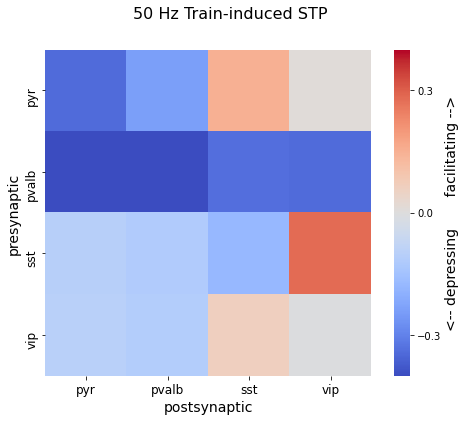

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(stp, cmap='coolwarm', vmin=-0.4, vmax=0.4, square=True, ax=ax,
                cbar_kws={"ticks":[-0.3, 0, 0.3], 'label': '<-- depressing       facilitating -->'})

fig.suptitle("50 Hz Train-induced STP", fontsize=16)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);
hm.figure.axes[-1].yaxis.label.set_size(14)
hm.tick_params(labelsize=12)